<a href="https://colab.research.google.com/github/HJJJJX/GEO_Practice/blob/main/11-TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlating and clustering time series using Dynamic Time Warping (DTW)

The introductory part of this notebook is based in part on [this article](https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd) and on the [DTW documentation for the 'librosa' package](https://librosa.org/librosa_gallery/auto_examples/plot_music_sync.html).

<a href="https://colab.research.google.com/github/UT-GEOML/GEO398D/blob/main/11-TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to dynamic time warping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/data.zip

--2024-04-17 20:16:04--  https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450929 (440K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 440.36K  --.-KB/s    in 0.04s   

2024-04-17 20:16:05 (11.9 MB/s) - ‘data.zip’ saved [450929/450929]



In [3]:
!unzip data.zip

Archive:  data.zip
  inflating: coordinates.csv         
  inflating: __MACOSX/._coordinates.csv  
  inflating: 42317348080000.csv      
  inflating: __MACOSX/._42317348080000.csv  
  inflating: 42317349040000.csv      
  inflating: __MACOSX/._42317349040000.csv  
  inflating: 42317349650000.csv      
  inflating: __MACOSX/._42317349650000.csv  
  inflating: 42317355540000.csv      
  inflating: __MACOSX/._42317355540000.csv  
  inflating: 42317355770000.csv      
  inflating: __MACOSX/._42317355770000.csv  
  inflating: 42317358370000.csv      
  inflating: __MACOSX/._42317358370000.csv  
  inflating: 42317364080000.csv      
  inflating: __MACOSX/._42317364080000.csv  
  inflating: 42317365560000.csv      
  inflating: __MACOSX/._42317365560000.csv  
  inflating: 42317366850000.csv      
  inflating: __MACOSX/._42317366850000.csv  
  inflating: audio_sir_duke_fast.mp3  
  inflating: __MACOSX/._audio_sir_duke_fast.mp3  
  inflating: audio_sir_duke_slow.mp3  
  inflating: __MACOSX/._au

Here are two recordings of the first bars of [the famous brass section lick in Stevie Wonder’s rendition of “Sir Duke”](https://www.youtube.com/watch?v=s6fPN5aQVDI). Due to differences in tempo, the first recording lasts for ca. 7 seconds and the second recording for ca. 5 seconds.

In [ ]:
from IPython.display import Audio
slow = Audio(filename='audio_sir_duke_slow.mp3')
display(slow)

In [ ]:
fast = Audio(filename='audio_sir_duke_fast.mp3')
display(fast)

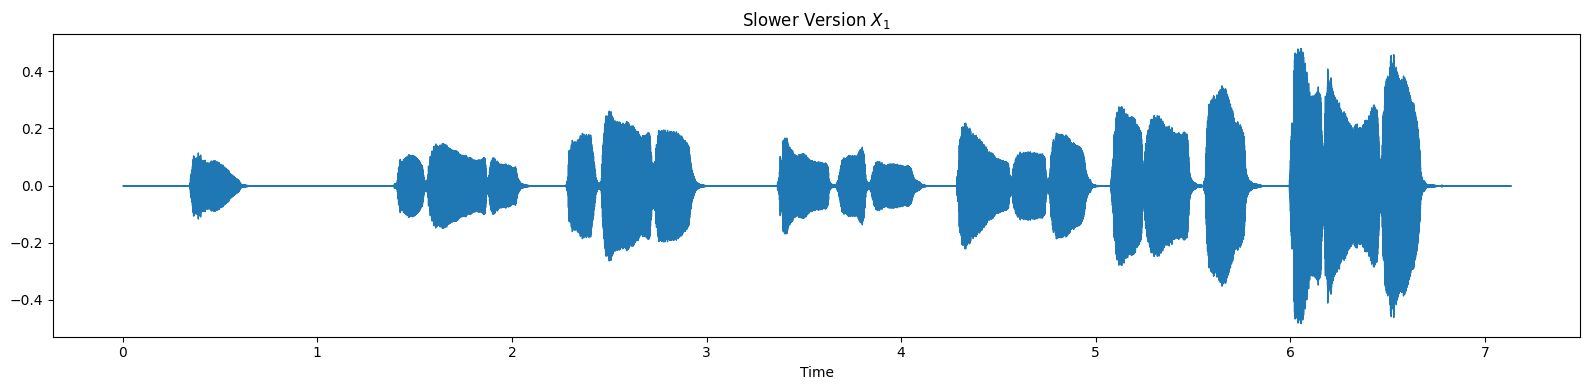

In [ ]:
import librosa
import librosa.display
x_1, fs = librosa.load('audio_sir_duke_slow.mp3')
plt.figure(figsize=(16, 4))
librosa.display.waveshow(x_1, sr=fs)
plt.title('Slower Version $X_1$')
plt.tight_layout()

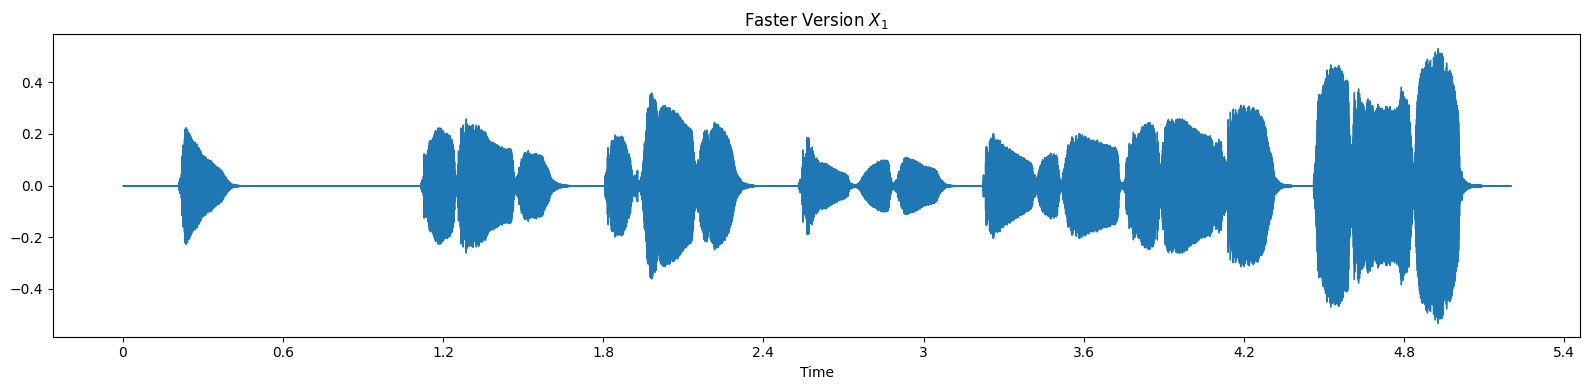

In [ ]:
x_1, fs = librosa.load('audio_sir_duke_fast.mp3')
plt.figure(figsize=(16, 4))
librosa.display.waveshow(x_1, sr=fs)
plt.title('Faster Version $X_1$')
plt.tight_layout()

The task is to find a mapping between the two sounds. The algorithm that is best suited for this goal is called 'dynamic time warping'. DTW is one of the algorithms for measuring similarity between two temporal sequences, which may vary in speed. DTW has been applied to:
* temporal sequences of video, audio, and graphics data
* automatic speech recognition  
* speaker recognition
* online signature recognition
* well log correlation
* tracking river migration

DTW can also be used as a distance measure between two sequences of unequal lengths, e.g., to perform classification / clustering.

After applying DTW, we can correlate time locations in one sound sequence to time locations in the other sequence:

![Music](https://librosa.org/librosa_gallery/_images/sphx_glr_plot_music_sync_005.png)

## Start from scratch

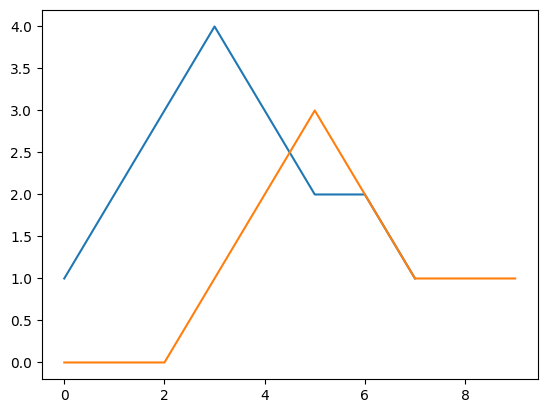

In [4]:
# create two short arrays and plot them:

a = np.array([1, 2, 3, 4, 3, 2, 2, 1])
b = np.array([0, 0, 0, 1, 2, 3, 2, 1, 1, 1])

plt.plot(a)
plt.plot(b);

The goal is to link every point in sequence 'a' to a point in sequence 'b' so that all point in 'b' also have an equivalent point in 'a'. To do this, we first compute a 'cost matrix' that is a table of the distances between all sample pairs in the sequences.

In [5]:
n, m = len(a), len(b)
cost_matrix = np.zeros((n, m))
for i in range(0, n): # rows
    for j in range(0, m): # columns
        cost = abs(a[i] - b[j])
        cost_matrix[i, j] = cost

cost_matrix.astype(int)

array([[1, 1, 1, 0, 1, 2, 1, 0, 0, 0],
       [2, 2, 2, 1, 0, 1, 0, 1, 1, 1],
       [3, 3, 3, 2, 1, 0, 1, 2, 2, 2],
       [4, 4, 4, 3, 2, 1, 2, 3, 3, 3],
       [3, 3, 3, 2, 1, 0, 1, 2, 2, 2],
       [2, 2, 2, 1, 0, 1, 0, 1, 1, 1],
       [2, 2, 2, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 2, 1, 0, 0, 0]])

<img src="https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/cost_matrix.gif" width="400">

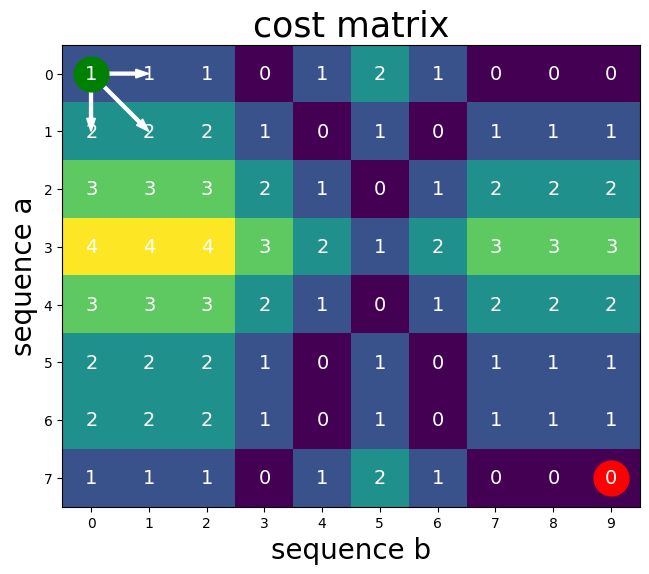

In [6]:
plt.figure(figsize=(10,6))
plt.imshow(cost_matrix)
plt.plot(0, 0, 'go', markersize=25)
plt.plot(m-1, n-1, 'ro', markersize=25)
plt.arrow(0, 0, 0, 1, color='w', width=0.05, length_includes_head=True)
plt.arrow(0, 0, 1, 0, color='w', width=0.05, length_includes_head=True)
plt.arrow(0, 0, 1, 1, color='w', width=0.05, length_includes_head=True)
plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m))
plt.yticks(np.arange(n))
for i in range(n):
    for j in range(m):
        plt.text(j-0.1, i+0.1, str(int(cost_matrix[i, j])), color='w', fontsize=14)
plt.title('cost matrix', fontsize=25);

Next we need to compute the 'DTW matrix', which the cumulative sum of the cost matrix, starting in the upper left corner and taking into account that movement is limited to down and to the right (that is, you cannot 'go back in time' in either of the sequences).

In [7]:
# initialize DTW matrix (= cumulative sum of cost matrix)
n, m = len(a), len(b)
dtw_matrix = np.inf * np.ones((n+1, m+1))
dtw_matrix[0, 0] = 0
dtw_matrix

array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]])

In [8]:
for i in range(1, n+1):
    for j in range(1, m+1):
        cost = abs(a[i-1] - b[j-1])
        # take last min from a square box
        last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
        dtw_matrix[i, j] = cost + last_min
dtw_matrix

array([[ 0., inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf,  1.,  2.,  3.,  3.,  4.,  6.,  7.,  7.,  7.,  7.],
       [inf,  3.,  3.,  4.,  4.,  3.,  4.,  4.,  5.,  6.,  7.],
       [inf,  6.,  6.,  6.,  6.,  4.,  3.,  4.,  6.,  7.,  8.],
       [inf, 10., 10., 10.,  9.,  6.,  4.,  5.,  7.,  9., 10.],
       [inf, 13., 13., 13., 11.,  7.,  4.,  5.,  7.,  9., 11.],
       [inf, 15., 15., 15., 12.,  7.,  5.,  4.,  5.,  6.,  7.],
       [inf, 17., 17., 17., 13.,  7.,  6.,  4.,  5.,  6.,  7.],
       [inf, 18., 18., 18., 13.,  8.,  8.,  5.,  4.,  4.,  4.]])

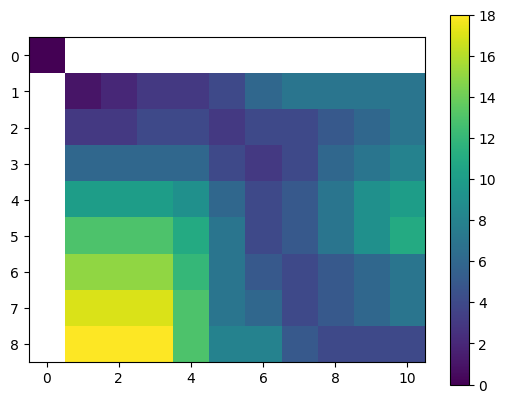

In [9]:
plt.imshow(dtw_matrix)
plt.colorbar();

The overall distance between a and b is the last element of the DTW matrix, which in this case is 4.

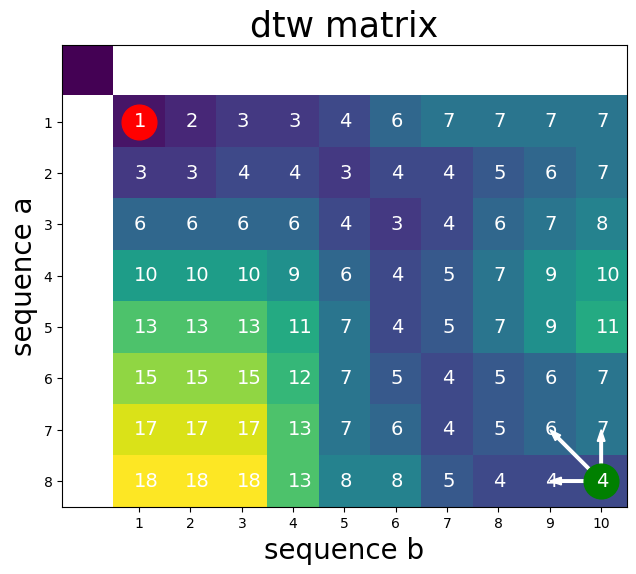

In [10]:
plt.figure(figsize=(10,6))
plt.imshow(dtw_matrix)
plt.plot(1, 1, 'ro', markersize=25)
plt.plot(m, n, 'go', markersize=25)

plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m+1)[1:])
plt.yticks(np.arange(n+1)[1:])
for i in range(1, n+1):
    for j in range(1, m+1):
        plt.text(j-0.1, i+0.1, str(int(dtw_matrix[i, j])), color='w', fontsize=14)

plt.arrow(10, 8, 0, -1, color='w', width=0.05, length_includes_head=True)
plt.arrow(10, 8, -1, 0, color='w', width=0.05, length_includes_head=True)
plt.arrow(10, 8, -1, -1, color='w', width=0.05, length_includes_head=True)

plt.title('dtw matrix', fontsize=25);

In [11]:
# backtracking:

path = [(n, m)]
i = 0
j = 0
while i < n:
    ind = np.argmin([dtw_matrix[n-i-1, m-j], dtw_matrix[n-i, m-j-1], dtw_matrix[n-i-1, m-j-1]])
    if ind == 0:
        i = i + 1
    if ind == 1:
        j = j + 1
    if ind == 2:
        i = i + 1
        j = j + 1
    path.append((n-i, m-j))
path = np.array(path)[:-1, :] - 1 # get rid of last element

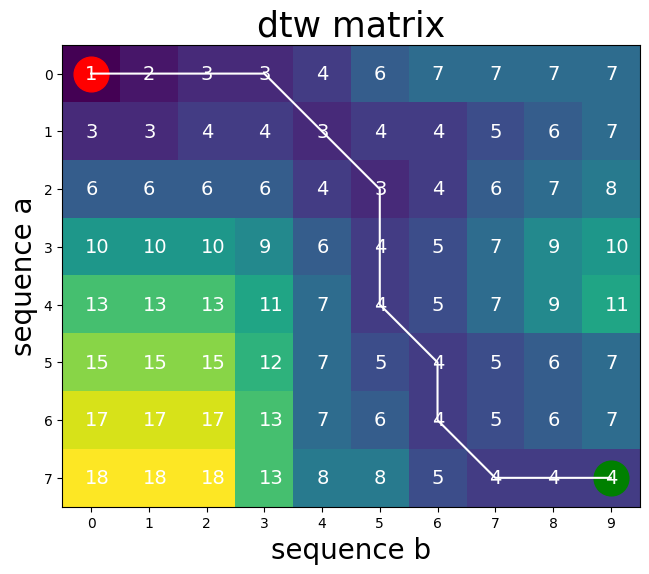

In [12]:
dtw_matrix = dtw_matrix[1:, 1:] # get rid of forts row and first column

plt.figure(figsize=(10,6))
plt.imshow(dtw_matrix)
plt.plot(0, 0, 'ro', markersize=25)
plt.plot(m-1, n-1, 'go', markersize=25)

plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m))
plt.yticks(np.arange(n))
for i in range(0, n):
    for j in range(0, m):
        plt.text(j-0.1, i+0.1, str(int(dtw_matrix[i, j])), color='w', fontsize=14)

plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'w')
plt.title('dtw matrix', fontsize=25);

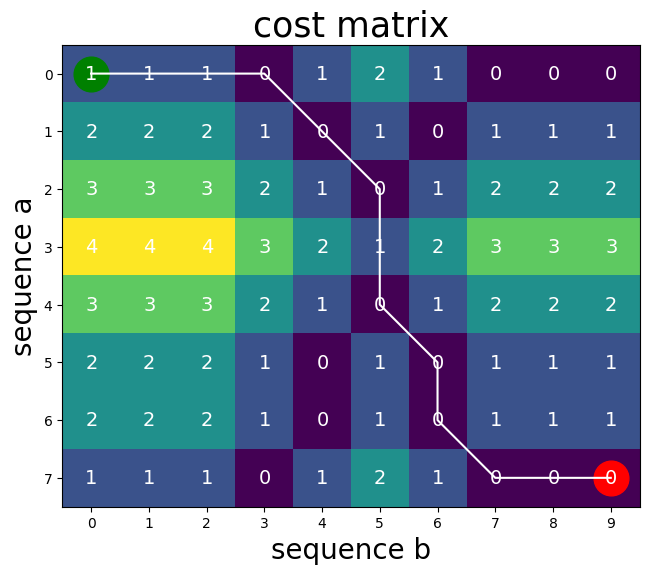

In [13]:
plt.figure(figsize=(10,6))
plt.imshow(cost_matrix)
plt.plot(0, 0, 'go', markersize=25)
plt.plot(m-1, n-1, 'ro', markersize=25)
plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m))
plt.yticks(np.arange(n))
for i in range(n):
    for j in range(m):
        plt.text(j-0.1, i+0.1, str(int(cost_matrix[i, j])), color='w', fontsize=14)
plt.title('cost matrix', fontsize=25);

plt.plot(path[:,1], path[:,0], 'w');

## Create DTW function

In [14]:
def dtw(s, t):
    # initialize dtw matrix:
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    # compute dtw matrix:
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min

    # backtracking:
    path = [(n, m)]
    i = 0
    j = 0
    while i < n:
        ind = np.argmin([dtw_matrix[n-i-1, m-j], dtw_matrix[n-i, m-j-1], dtw_matrix[n-i-1, m-j-1]])
        if ind == 0:
            i = i + 1
        if ind == 1:
            j = j + 1
        if ind == 2:
            i = i + 1
            j = j + 1
        path.append((n-i, m-j))

    path = np.array(path)[:-1, :] - 1 # get rid of last element
    dtw_matrix = dtw_matrix[1:, 1:] # get rid of first column and first row

    return dtw_matrix, path

In [15]:
dtw_matrix, path = dtw(a, b)

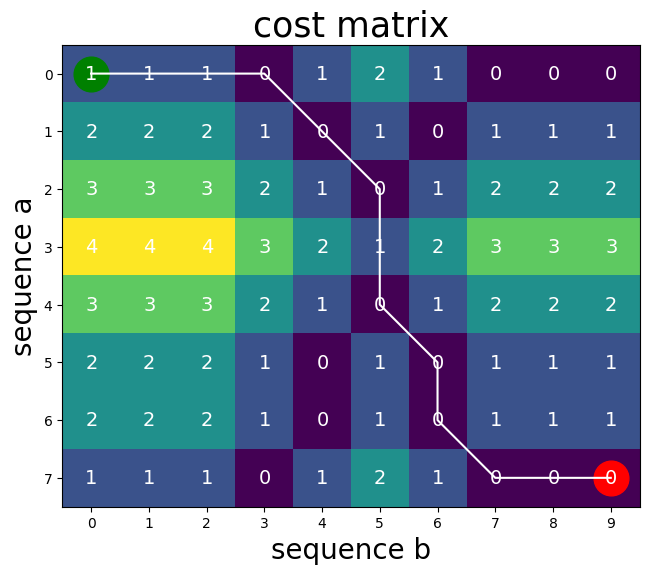

In [16]:
plt.figure(figsize=(10,6))
plt.imshow(cost_matrix)
plt.plot(0, 0, 'go', markersize=25)
plt.plot(m-1, n-1, 'ro', markersize=25)
plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m))
plt.yticks(np.arange(n))
for i in range(n):
    for j in range(m):
        plt.text(j-0.1, i+0.1, str(int(cost_matrix[i, j])), color='w', fontsize=14)
plt.title('cost matrix', fontsize=25);

plt.plot(path[:,1], path[:,0], 'w');

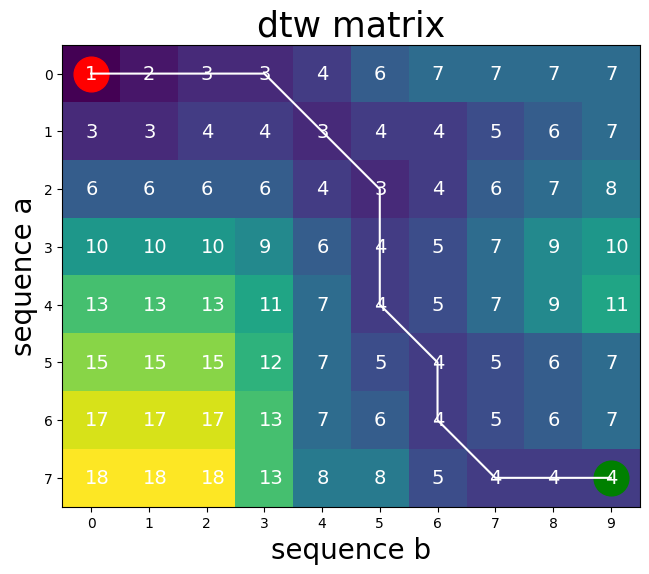

In [17]:
plt.figure(figsize=(10,6))
plt.imshow(dtw_matrix)
plt.plot(0, 0, 'ro', markersize=25)
plt.plot(m-1, n-1, 'go', markersize=25)

plt.xlabel('sequence b', fontsize=20)
plt.ylabel('sequence a', fontsize=20)
plt.xticks(np.arange(m))
plt.yticks(np.arange(n))
for i in range(0, n):
    for j in range(0, m):
        plt.text(j-0.1, i+0.1, str(int(dtw_matrix[i, j])), color='w', fontsize=14)

plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'w')
plt.title('dtw matrix', fontsize=25);

## Adding constraints

Sometimes it is necessary to restrict the correlation so that it does not involve skipping too many samples from either sequence. The most common way to do this is the 'Sakoe-Chiba' band, which we will look at next (although we will not use it in the applied example).

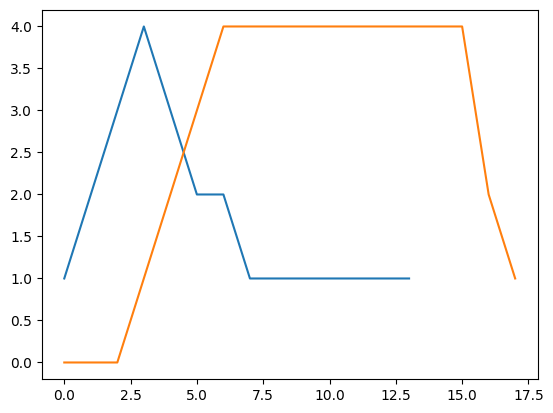

In [18]:
a = np.array([1, 2, 3, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1])
b = np.array([0, 0, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1])

plt.plot(a)
plt.plot(b);

In [19]:
dtw_matrix, path = dtw(a, b)

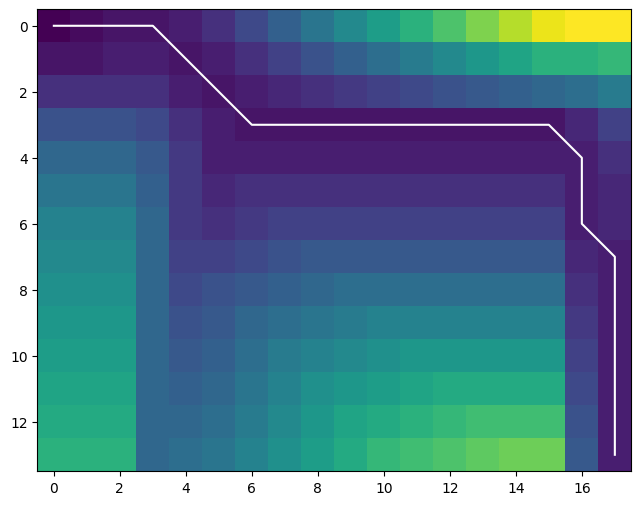

In [20]:
plt.figure(figsize=(10,6))
plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'w');

In [21]:
old_path = path[:]

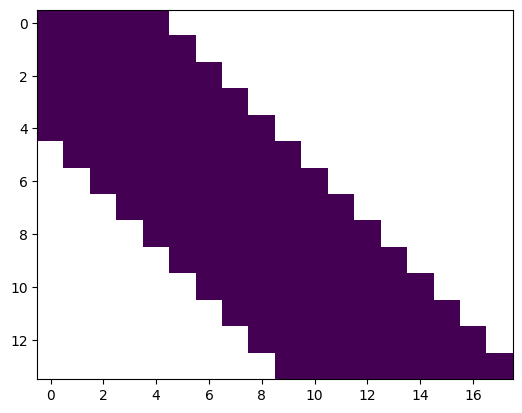

In [22]:
window = 4

n, m = len(a), len(b)
dtw_matrix = np.zeros((n+1, m+1))
for i in range(n+1):
    for j in range(m+1):
        dtw_matrix[i, j] = np.inf
dtw_matrix[0, 0] = 0

for i in range(1, n+1):
    for j in range(np.max([1, i-window]), np.min([m, i+window])+1):
        dtw_matrix[i, j] = 0

plt.imshow(dtw_matrix[1:, 1:]);

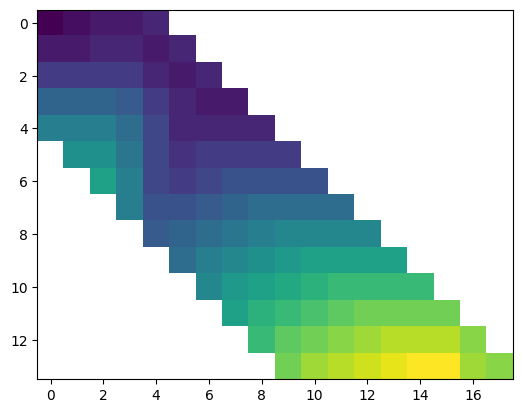

In [23]:
for i in range(1, n+1):
    for j in range(np.max([1, i-window]), np.min([m, i+window])+1):
        cost = abs(a[i-1] - b[j-1])
        # take last min from a square box
        last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
        dtw_matrix[i, j] = cost + last_min

plt.imshow(dtw_matrix[1:, 1:]);

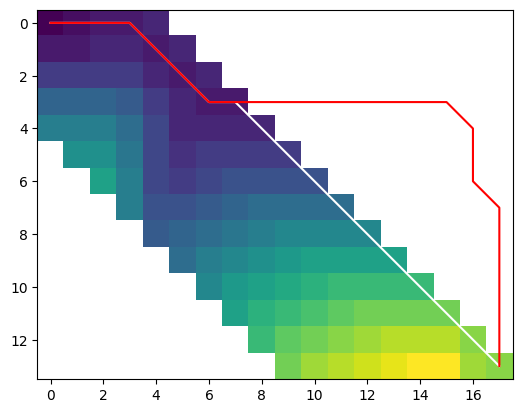

In [24]:
# backtracking

path = [(n, m)]
i = 0
j = 0
while i < n:
    ind = np.argmin([dtw_matrix[n-i-1, m-j], dtw_matrix[n-i, m-j-1], dtw_matrix[n-i-1, m-j-1]])
    if ind == 0:
        i = i + 1
    if ind == 1:
        j = j + 1
    if ind == 2:
        i = i + 1
        j = j + 1
    path.append((n-i, m-j))
path = np.array(path)[:-1, :]

plt.imshow(dtw_matrix[1:, 1:])
plt.plot(path[:,1]-1, path[:,0]-1, 'w')
plt.plot(old_path[:,1], old_path[:,0], 'r')

In [25]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    w = np.max([window, abs(n-m)])

    # initialize dtw matrix:
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0

    # define Sakoe-Chiba band:
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0

    # compute dtw matrix:
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min

    # backtracking:
    path = [(n, m)]
    i = 0
    j = 0
    while i < n:
        ind = np.argmin([dtw_matrix[n-i-1, m-j], dtw_matrix[n-i, m-j-1], dtw_matrix[n-i-1, m-j-1]])
        if ind == 0:
            i = i + 1
        if ind == 1:
            j = j + 1
        if ind == 2:
            i = i + 1
            j = j + 1
        path.append((n-i, m-j))

    path = np.array(path)[:-1, :] - 1 # get rid of last element
    dtw_matrix = dtw_matrix[1:, 1:] # get rid of first column and first row

    return dtw_matrix, path

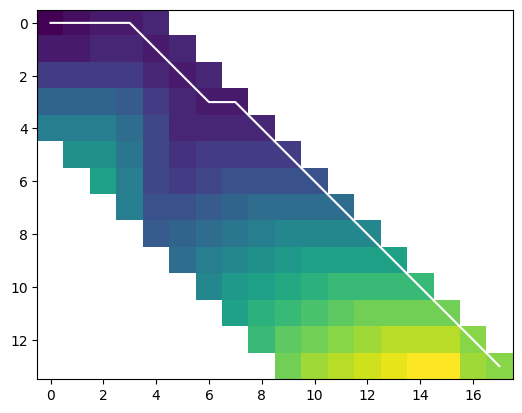

In [26]:
dtw_matrix, path = dtw(a, b, 4)
plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'w');

## Try DTW on real data

In [ ]:
ls

42317348080000.csv  42317355540000.csv  42317364080000.csv  audio_sir_duke_fast.mp3  data.zip
42317349040000.csv  42317355770000.csv  42317365560000.csv  audio_sir_duke_slow.mp3  __MACOSX/
42317349650000.csv  42317358370000.csv  42317366850000.csv  coordinates.csv          sample_data/


In [27]:
# read two gamma ray logs

df = pd.read_csv('42317366850000.csv')
log_a = np.array(df['normalized gamma ray'])
md_a = np.array(df['depth (m)'])

df = pd.read_csv('42317355540000.csv')
log_b = np.array(df['normalized gamma ray'])
md_b= np.array(df['depth (m)'])

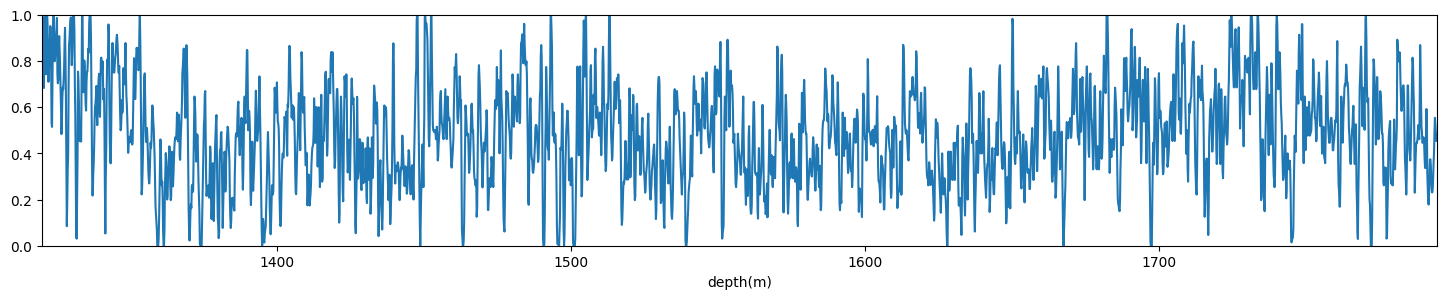

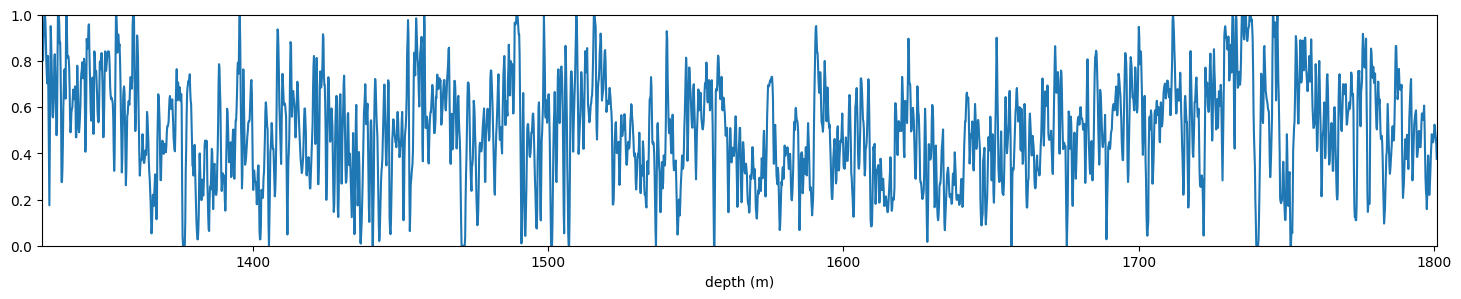

In [28]:
fig = plt.figure(figsize=(18,3))
plt.plot(md_a, log_a)
plt.ylim(0,1)
plt.xlim(md_a[0], md_a[-1])
plt.xlabel('depth(m)')
fig = plt.figure(figsize=(18,3))
plt.plot(md_b, log_b)
plt.ylim(0,1)
plt.xlim(md_b[0], md_b[-1])
plt.xlabel('depth (m)');

In [29]:
%%time
dtw_matrix, path = dtw(log_a, log_b, window = 500)

CPU times: user 22 s, sys: 124 ms, total: 22.1 s
Wall time: 22.5 s


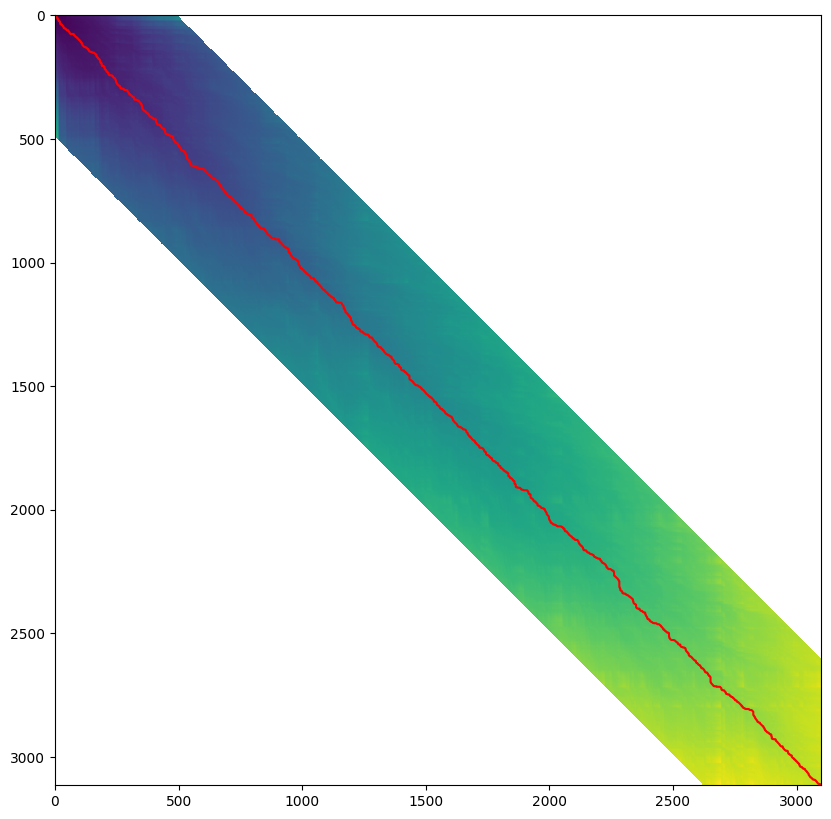

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'r');

In [31]:
# simple function for plotting correlation

def plot_correlation(log1, log2, d1, d2, p, q, step):
    fig = plt.figure(figsize=(6,20))
    ax = fig.add_subplot(111)
    ax.plot(log1, d1-np.min(d1), 'b', linewidth=1)
    ax.plot(log2 + 2, d2-np.min(d2), 'b', linewidth=1)
    ax.plot([1, 1],[0, np.max(d1-np.min(d1))], 'k', linewidth=0.5)
    ax.plot([2, 2],[0, np.max(d2-np.min(d2))], 'k', linewidth=0.5)
    ax.set_xlim(0, 3)
    ax.set_ylim(0, max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2))))
    for i in range(0, len(p)-step, step):
        # intervals for log on the left:
        depth1_base = d1[p[i]]-np.min(d1)
        depth1_top = d1[p[i+step]]-np.min(d1)
        if p[i+step] < p[i]:
            mean_log1 = np.mean(log1[p[i+step]: p[i]])
            fillcolor = [1-0.4*mean_log1,1-0.7*mean_log1,0.6-0.6*mean_log1]
            x = [0, 1, 1, 0]
            y = [depth1_base, depth1_base, depth1_top, depth1_top]
            plt.fill(x, y, color=fillcolor)
        else:
            mean_log1 = log1[p[i]]
        # intervals for log on the right:
        depth2_base = d2[q[i]]-np.min(d2)
        depth2_top = d2[q[i+step]]-np.min(d2)
        if q[i+step] < q[i]:
            mean_log2 = np.mean(log2[q[i+step]: q[i]])
            fillcolor = [1-0.4*mean_log2,1-0.7*mean_log2,0.6-0.6*mean_log2]
            x = [2, 3, 3, 2]
            y = [depth2_base, depth2_base, depth2_top, depth2_top]
            plt.fill(x, y, color=fillcolor)
        else:
            mean_log2 = log2[q[i]]
        # intervals between the two logs:
        if (p[i+step] < p[i]) or (q[i+step] < q[i]):
            mean_logs = (mean_log1 + mean_log2)*0.5
            x = [1, 2, 2, 1]
            y = [depth1_base, depth2_base, depth2_top, depth1_top]
            fillcolor = [1-0.4*mean_logs,1-0.7*mean_logs,0.6-0.6*mean_logs]
            plt.fill(x, y, color=fillcolor)
    plt.xticks([])
    plt.ylabel('depth (m)', fontsize=14)
    plt.gca().invert_yaxis()

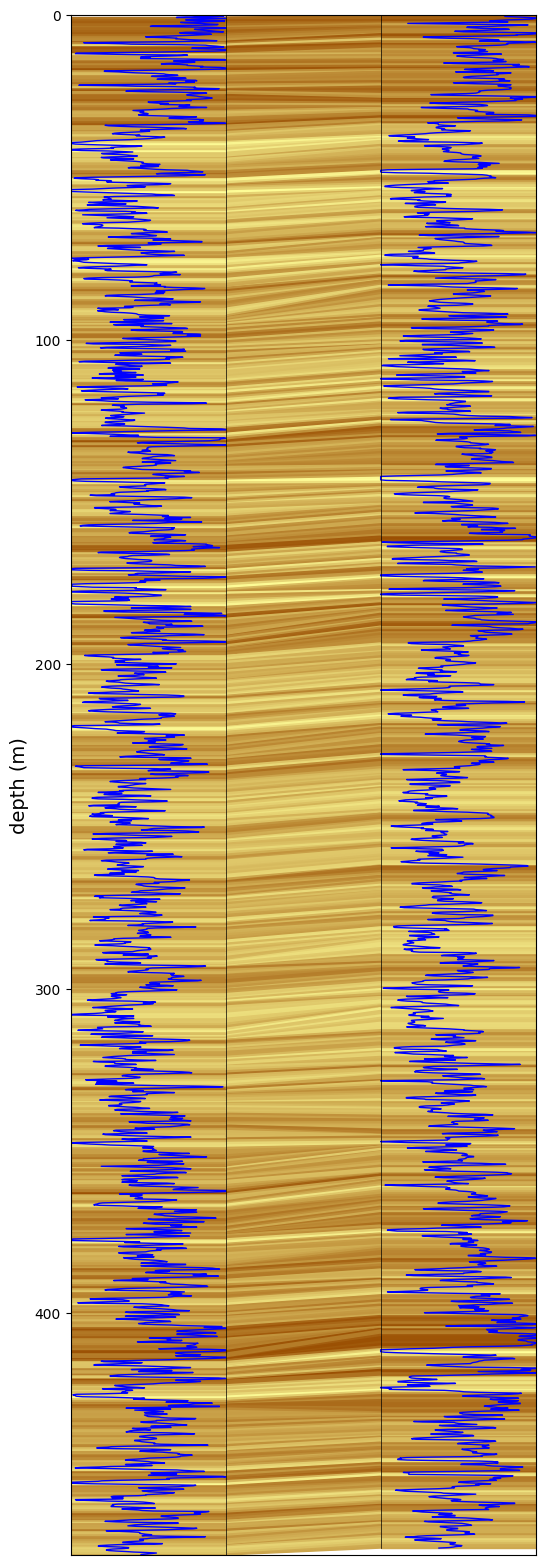

In [32]:
plot_correlation(log_a, log_b, md_a, md_b, path[:,0], path[:,1], 5)

## Use a faster implementation

In [33]:
from librosa.sequence import dtw as lib_dtw

In [34]:
%%time
D, wp = lib_dtw(log_a.T, log_b.T)

CPU times: user 896 ms, sys: 42.3 ms, total: 939 ms
Wall time: 937 ms


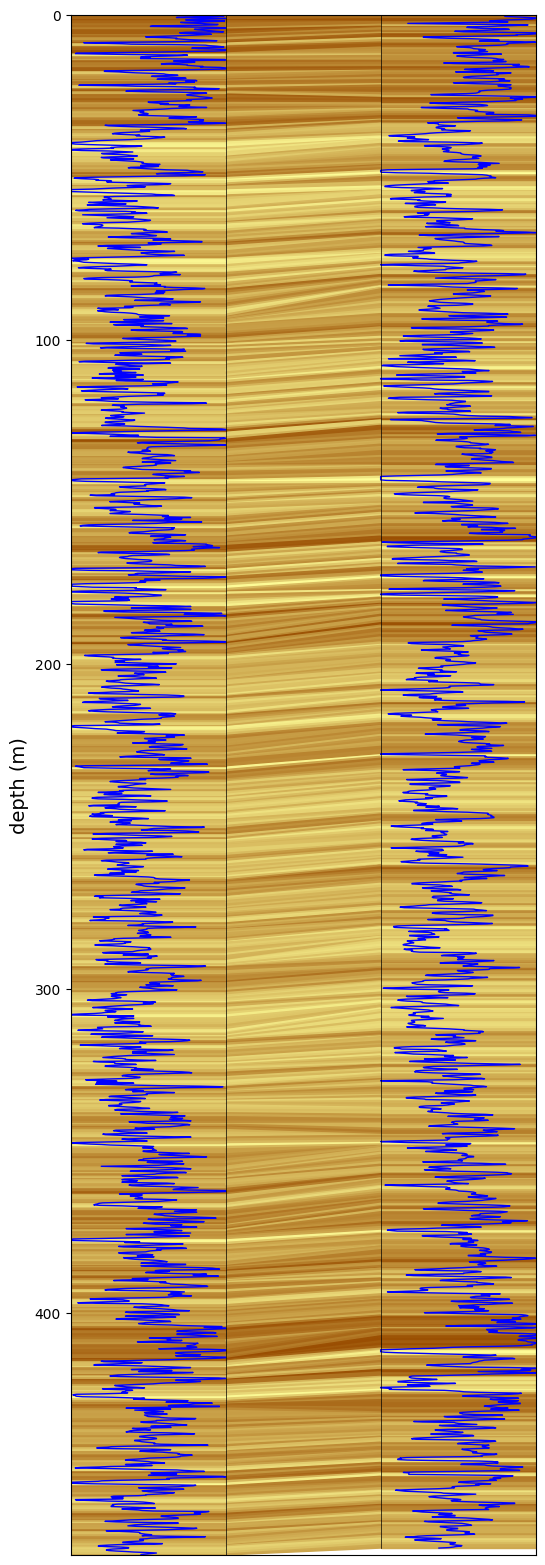

In [35]:
plot_correlation(log_a, log_b, md_a, md_b, wp[:,0], wp[:,1], 5)

Now let's compare the results from librosa's DTW with our implementation:

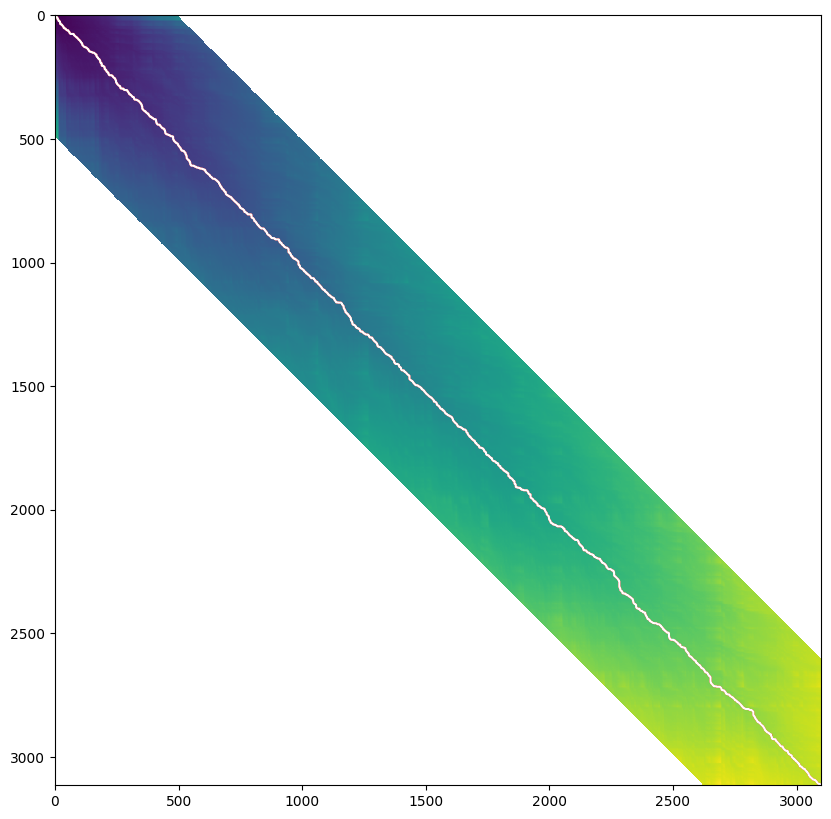

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(dtw_matrix)
plt.plot(path[:,1], path[:,0], 'r')
plt.plot(wp[:,1], wp[:,0], 'w');

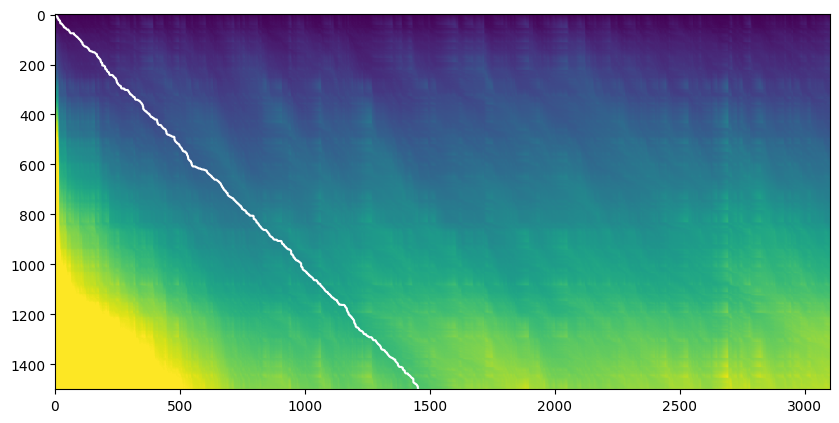

In [37]:
# librosa allows for correlating subsequences:

D, wp = lib_dtw(log_a[:1500].T, log_b.T, subseq=True)
plt.figure(figsize=(10, 10))
plt.imshow(D, vmin=0, vmax=150)
plt.plot(wp[:,1], wp[:,0], 'w')

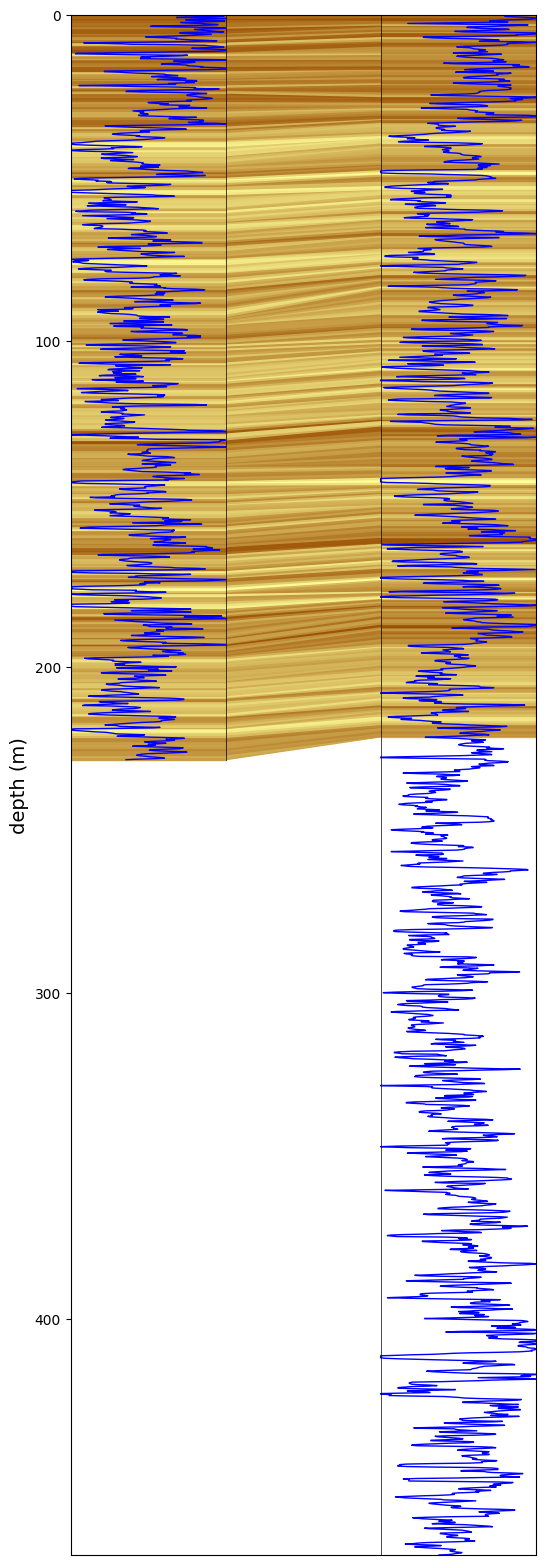

In [38]:
plot_correlation(log_a[:1500], log_b, md_a[:1500], md_b, wp[:,0], wp[:,1], 5)

The 'librosa' library's 'dtw' function uses by default the euclidean distance between the two arrays:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html.
This works in most cases where the two series are quite similar but well logs show a lot of variation and it is usually not realistic to give too much weight to little changes in log values from one log to the other. Therefore, following Wheeler and Hale (2014), we use an exponent to reduce the impact of these minor differences and to get an overall more layercake correlation. The next cell compares the euclidian-distance-based warping result with the new approach.  

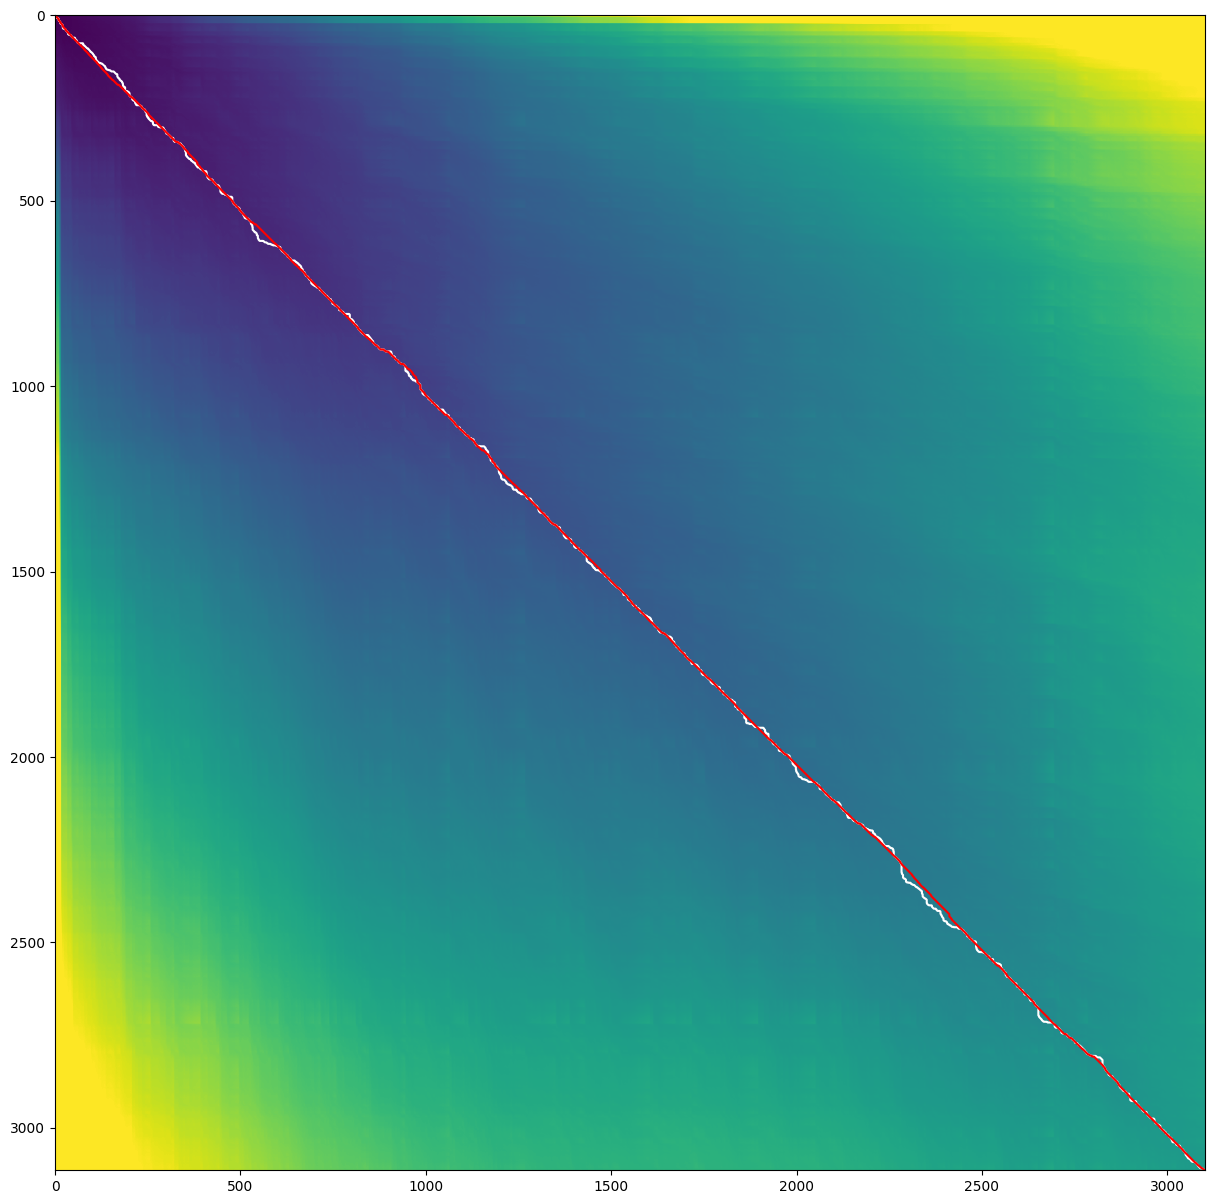

In [39]:
D, wp = lib_dtw(log_a.T, log_b.T)
plt.figure(figsize=(15, 15))
plt.imshow(D, vmin=0, vmax=400)
plt.plot(wp[:,1], wp[:,0], 'w')

r = len(log_a)
c = len(log_b)
exponent = 0.15
sm = np.zeros((r,c)) # similarity matrix
for i in range(0,r):
    sm[i,:] = (np.abs(np.array(log_b).flatten() - log_a[i]))**exponent
D, wp = lib_dtw(C = sm)
plt.plot(wp[:,1], wp[:,0], 'r');

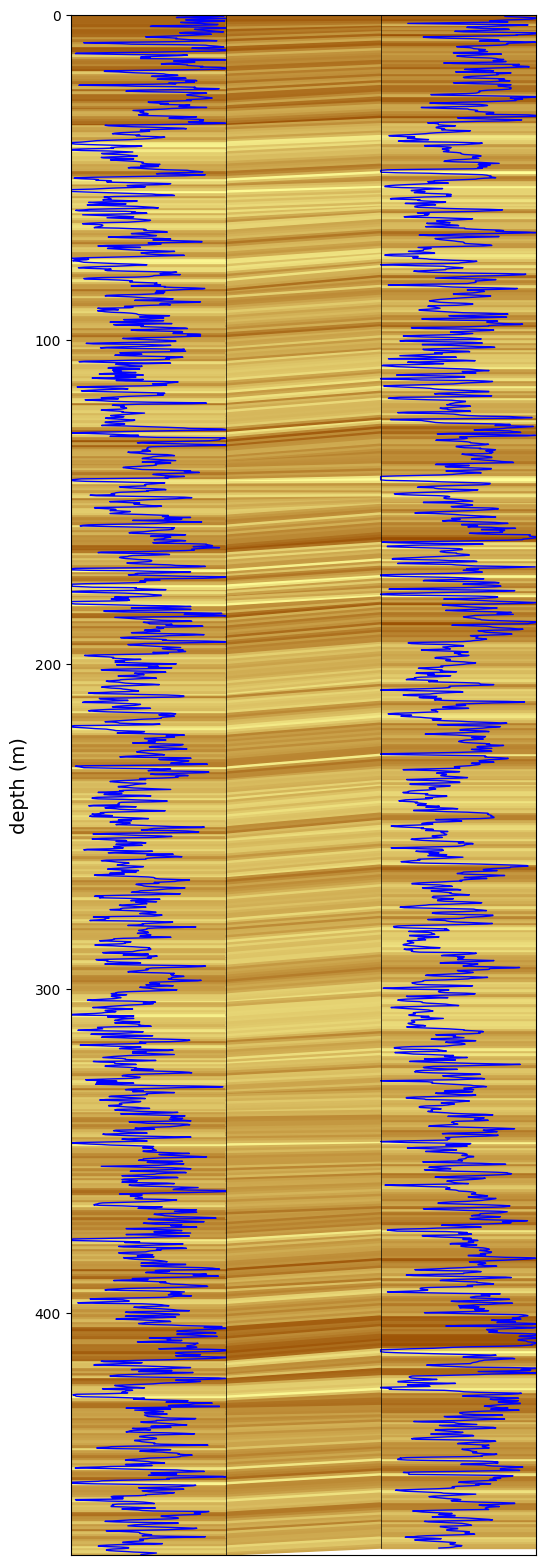

In [40]:
plot_correlation(log_a, log_b, md_a, md_b, wp[:,0], wp[:,1], 5)

## Warning! ##

DTW will correlate two sequences even if there is absolutely no reason to correlate them. An easy way to demonstrate this is to flip one of the logs upside down and plot the DTW correlation result.

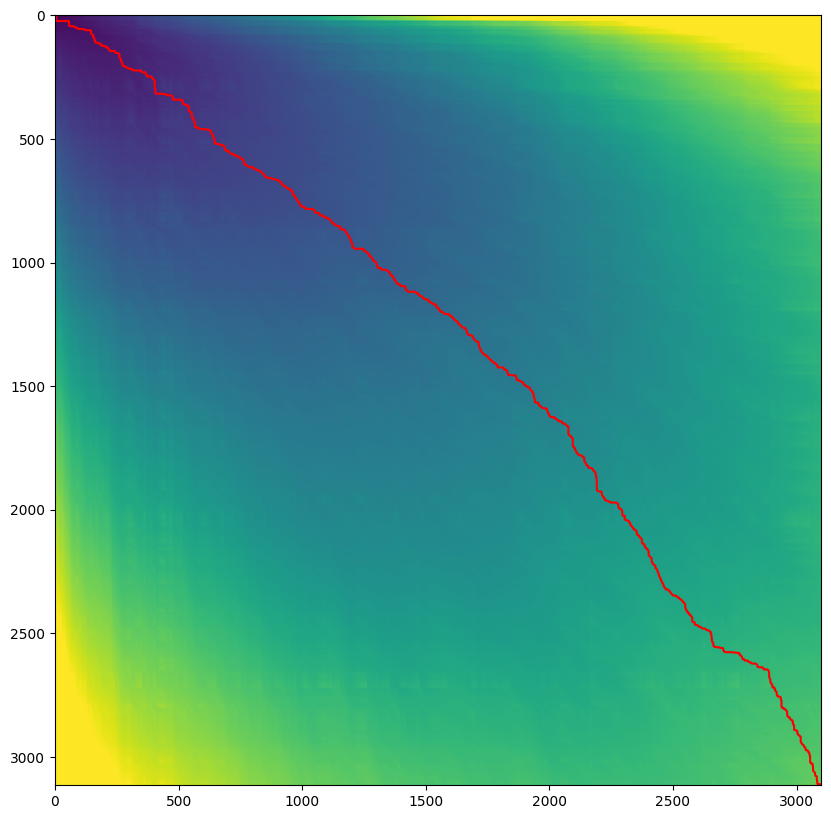

In [ ]:
D, wp = lib_dtw(log_a.T, log_b[::-1].T, metric='euclidean')
plt.figure(figsize=(10, 10))
plt.imshow(D, vmin=0, vmax=400)
plt.plot(wp[:,1], wp[:,0], 'r');

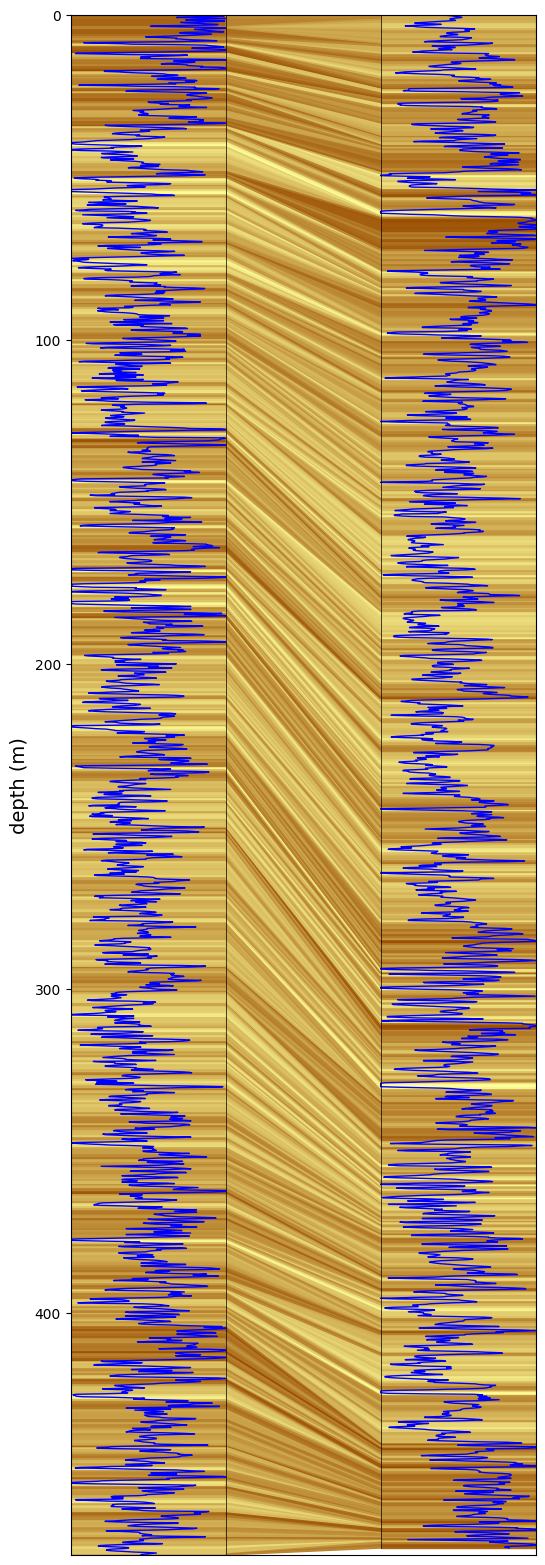

In [ ]:
plot_correlation(log_a, log_b[::-1], md_a, md_b, wp[:,0], wp[:,1], 5)

### Correlating multiple logs

Although dynamic time warping works well when correlating two time series, the pairwise correlations are going to be in conflict with each other if you work with multiple logs / time series. See [this](https://onlinelibrary.wiley.com/doi/10.1111/bre.12787) paper for details on one approach to deal with this problem.

## Time series clustering using DTW

### Using a continuous wavelet transform to split time series into segments

Instead of splitting our logs into segments manually, we can automtae the process by applying a continuous wavelet transform (CWT) to the logs. This means that we convolve the log with a wavelet of variable scale, to generate smoothed versions of the log at different scales. The segment boundaries then can be determined by tracking the zero contours on the CWT matrix to the smallest scale.

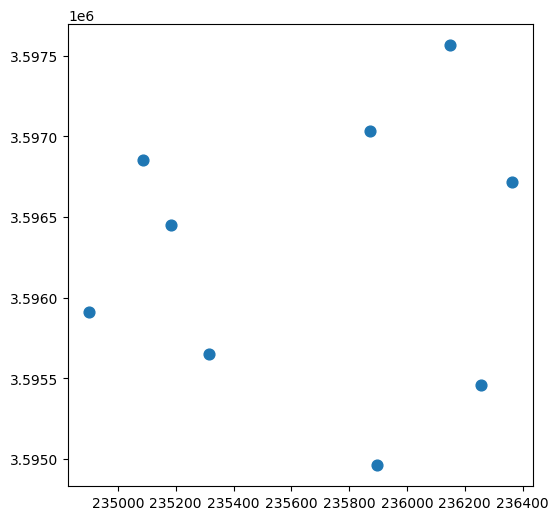

In [41]:
# load the data first

df = pd.read_csv('coordinates.csv')
plt.figure(figsize=(6,6))
plt.scatter(df['x (m)'], df['y (m)'], s=60)
UWIs = list(df['UWI'])

logs = []
mds = []

for i in range(len(UWIs)):
    df_log = pd.read_csv(str(UWIs[i]) + '.csv')
    logs.append(np.array(df_log['normalized gamma ray']))
    mds.append(np.array(df_log['depth (m)']))

In [42]:
from scipy import signal
from skimage import measure

wavelet = signal.ricker # generate Ricker wavelet
widths = np.arange(1, 600) # vector for widths (scales) used for continuous wavelet transform
cwt_all = signal.cwt(logs[0], wavelet, widths) # create continuous wavelet transform

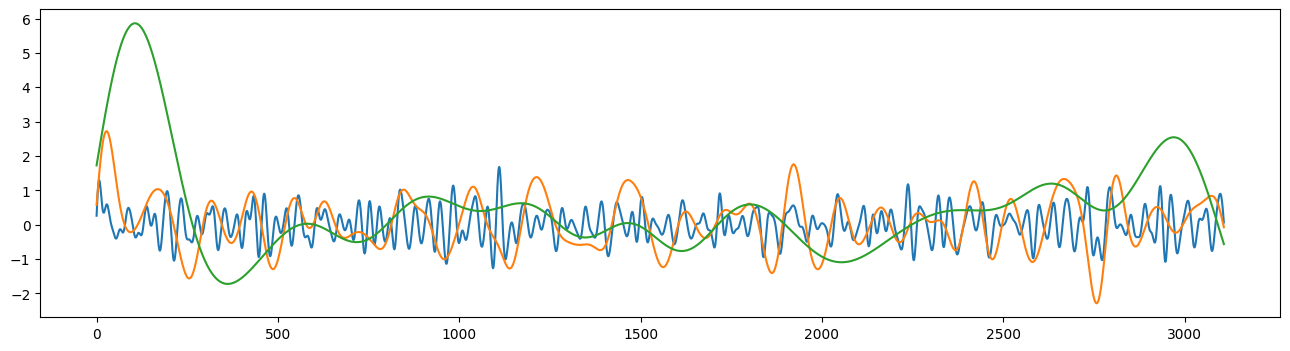

In [43]:
# convolutions at different scales
plt.figure(figsize=(16, 4))
plt.plot(cwt_all.T[:,8])
plt.plot(cwt_all.T[:,32])
plt.plot(cwt_all.T[:,128]);

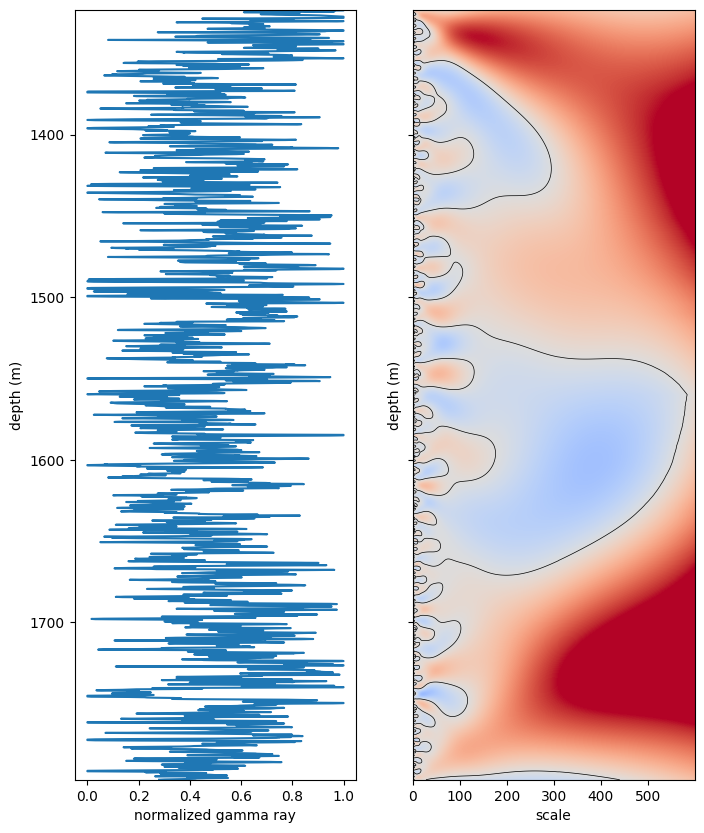

In [44]:
fig, axes = plt.subplots(nrows=1, ncols = 2, sharey=True, figsize=(8, 10))
axes[0].plot(logs[0], mds[0])
axes[0].set_xlabel('normalized gamma ray')
axes[0].set_ylabel('depth (m)')
axes[1].imshow(cwt_all.T, cmap='coolwarm', extent=[0, widths[-1], mds[0][-1], mds[0][0]], aspect='auto', vmin=-6, vmax=6)
axes[1].contour(cwt_all.T[::-1,:], levels=[0], colors='k', extent=[0, widths[-1], mds[0][-1], mds[0][0]], linewidths=0.5)
axes[1].set_xlabel('scale')
axes[1].set_ylabel('depth (m)');

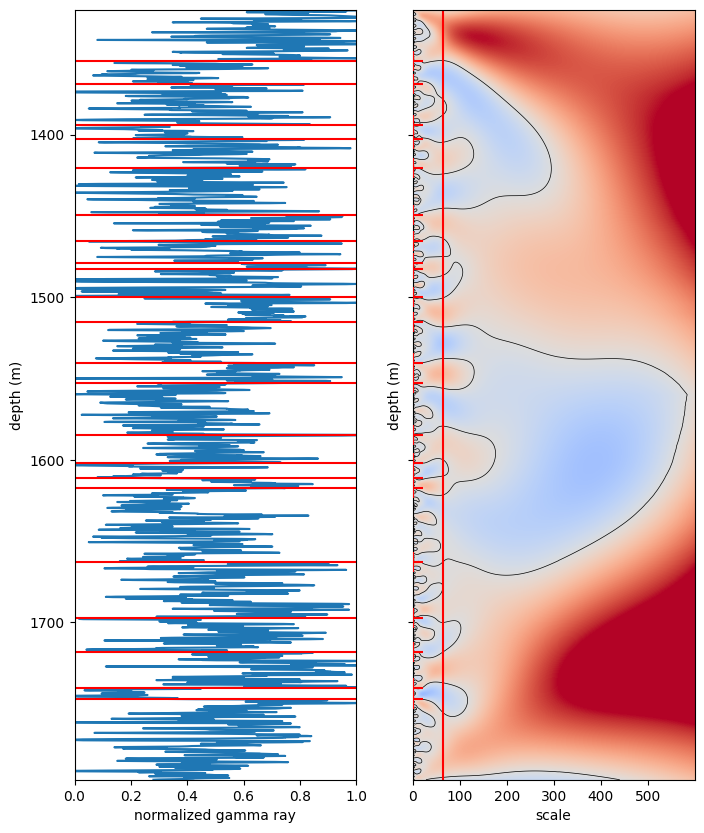

In [45]:
bounds=[] # list for finding boundaries
contours = measure.find_contours(cwt_all.T, 0)
scale = 64
for i in range(0,len(contours)):
    x = contours[i][:,0]
    y = contours[i][:,1]
    dec, dummy = np.modf(y) # get rid of points that do not coincide with an integer y value
    x = x[dec==0.0]
    y = y[dec==0.0]
    if scale in y: # append level 1 value to list, at both ends of the contourline
        # but only do that if the line ending corresponds to y=0
        if y[0]==0.0:
              bounds.append(x[0])
        if y[-1]==0.0:
              bounds.append(x[-1])
bounds.sort()
bounds = np.array(bounds).astype(int)
dbounds = mds[0][bounds]

fig, axes = plt.subplots(nrows=1, ncols = 2, sharey=True, figsize=(8, 10))
axes[0].plot(logs[0], mds[0])
for dbound in dbounds:
    axes[0].plot([0, 1], [dbound, dbound], 'r')
axes[0].set_xlabel('normalized gamma ray')
axes[0].set_ylabel('depth (m)')
axes[0].set_xlim(0, 1)
axes[1].imshow(cwt_all.T, cmap='coolwarm', extent=[0, widths[-1], mds[0][-1], mds[0][0]], aspect='auto', vmin=-6, vmax=6)
axes[1].contour(cwt_all.T[::-1,:], levels=[0], colors='k', extent=[0, widths[-1], mds[0][-1], mds[0][0]], linewidths=0.5)
axes[1].plot([scale, scale], [mds[0][-1], mds[0][0]], 'r')
axes[1].scatter(np.zeros(np.shape(dbounds)), dbounds, s=200, c='r', zorder=1000, marker='+')
axes[1].set_xlabel('scale')
axes[1].set_ylabel('depth (m)');

In [46]:
def get_cwt_bounds(log, md, scale):
    wavelet = signal.ricker # generate Ricker wavelet
    widths = np.arange(1, 1000) # vector for widths (scales) used for continuous wavelet transform
    cwt_all = signal.cwt(log, wavelet, widths) # create continuous wavelet transform
    bounds=[] # list for finding boundaries
    contours = measure.find_contours(cwt_all.T, 0)
    for i in range(0,len(contours)):
        x = contours[i][:,0]
        y = contours[i][:,1]
        dec, dummy = np.modf(y) # get rid of points that do not coincide with an integer y value
        x = x[dec==0.0]
        y = y[dec==0.0]
        if scale in y: # append level 1 value to list, at both ends of the contourline
            # but only do that if the line ending corresponds to y=0
            if y[0]==0.0:
                 bounds.append(x[0])
            if y[-1]==0.0:
                 bounds.append(x[-1])
    bounds.sort()
    bounds = np.array(bounds).astype(int)
    dbounds = md[bounds]
    return bounds, dbounds

def collect_log_segments(logs, mds, ind, scale):
    log_segments = []
    segment_labels = []
    segment_bounds = []
    bounds, dbounds = get_cwt_bounds(logs[ind], mds[ind], scale)
    if bounds[0] != 0:
        bounds = np.hstack((0, bounds))
    if bounds[-1] != len(logs[ind]):
        bounds = np.hstack((bounds, len(logs[ind])))
    for i in range(len(bounds)-1):
        if len(logs[ind][bounds[i]:bounds[i+1]]) > 0:
            log_segments.append(logs[ind][bounds[i]:bounds[i+1]])
            segment_labels.append(ind)
            segment_bounds.append((bounds[i], bounds[i+1]))
    return bounds, dbounds, log_segments, segment_labels, segment_bounds

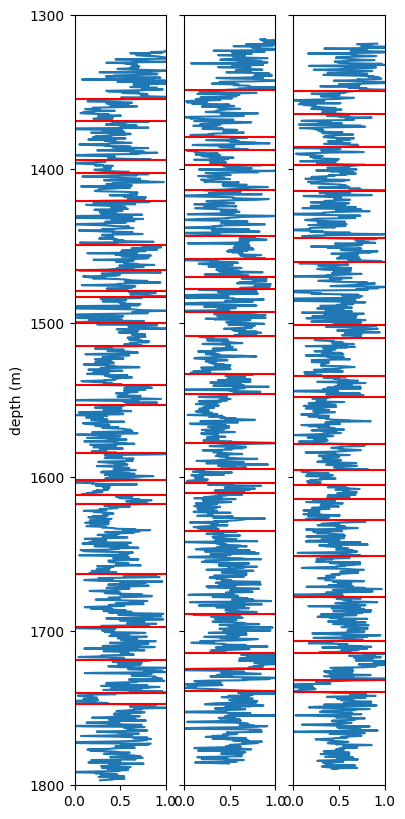

In [47]:
scale = 64
log_segments_all = []
segment_labels_all = []
segment_bounds_all = []
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols =3, sharey=True, figsize=(4,10))

ind = 0
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
for segment in log_segments:
    log_segments_all.append(segment)
for label in segment_labels:
    segment_labels_all.append(label)
for bound in segment_bounds:
    segment_bounds_all.append(bound)
ax1.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax1.plot([0, 1], [bound, bound], 'r')
ax1.set_ylabel('depth (m)')
ax1.set_xlim(0, 1)

ind = 1
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
for segment in log_segments:
    log_segments_all.append(segment)
for label in segment_labels:
    segment_labels_all.append(label)
for bound in segment_bounds:
    segment_bounds_all.append(bound)
ax2.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax2.plot([0, 1], [bound, bound], 'r')
ax2.set_xlim(0, 1)

ind = 2
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
for segment in log_segments:
    log_segments_all.append(segment)
for label in segment_labels:
    segment_labels_all.append(label)
for bound in segment_bounds:
    segment_bounds_all.append(bound)
ax3.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax3.plot([0, 1], [bound, bound], 'r')
ax3.set_xlim(0, 1)
ax3.set_ylim(1800, 1300);

### Using `tslearn` to apply k-means clustering to log segments

`tslearn` is a Python package that provides machine learning tools for the analysis of time series. This package builds on (and hence depends on) `scikit-learn`, `numpy` and `scipy` libraries. `tslearn` has a number of methods that makes it possible to work with time series of variable lengths (e.g., DTW).

[source](https://tslearn.readthedocs.io/en/stable/index.html)

In [ ]:
pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
n_clusters = 6
X = to_time_series_dataset(log_segments_all) # convert log segments to time series dataset
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw") # k-means clustering model instance
labels = km.fit_predict(X) # fit model to data

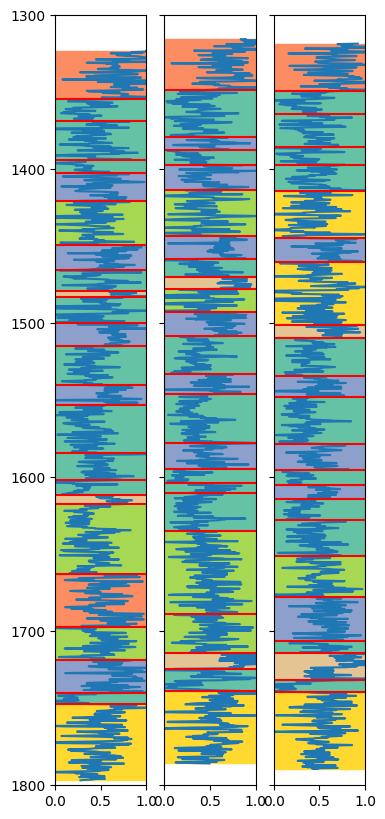

In [ ]:
from matplotlib import cm
cmap = cm.Set2

scale = 64
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(4,10))

ind = 0
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
ax1.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax1.plot([0, 1], [bound, bound], 'r')
for i in range(len(segment_labels_all)):
    if segment_labels_all[i] == ind:
        top = mds[ind][segment_bounds_all[i][0]]
        base = mds[ind][segment_bounds_all[i][1]-1]
        ax1.fill([0, 1, 1, 0], [base, base, top, top], color=cmap(labels[i]/n_clusters))
ax1.set_xlim(0, 1)

ind = 1
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
ax2.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax2.plot([0, 1], [bound, bound], 'r')
for i in range(len(segment_labels_all)):
    if segment_labels_all[i] == ind:
        top = mds[ind][segment_bounds_all[i][0]]
        base = mds[ind][segment_bounds_all[i][1]-1]
        ax2.fill([0, 1, 1, 0], [base, base, top, top], color=cmap(labels[i]/n_clusters))
ax2.set_xlim(0, 1)

ind = 2
bounds, dbounds, log_segments, segment_labels, segment_bounds = collect_log_segments(logs, mds, ind, scale)
ax3.plot(logs[ind], mds[ind])
for bound in dbounds:
    ax3.plot([0, 1], [bound, bound], 'r')
for i in range(len(segment_labels_all)):
    if segment_labels_all[i] == ind:
        top = mds[ind][segment_bounds_all[i][0]]
        base = mds[ind][segment_bounds_all[i][1]-1]
        ax3.fill([0, 1, 1, 0], [base, base, top, top], color=cmap(labels[i]/n_clusters))
ax3.set_xlim(0, 1)
ax3.set_ylim(1800, 1300);

## Using DTW to track river migration

See [this blog post](https://zsylvester.github.io/post/curvature_migration_rate/) for more detail.

<img src="https://zsylvester.github.io/img/bank_migration_dtw.png" width="600"/>

# Task 1

You are given two channel centerlines: the first one corresponds to a segment of Rio Jurua (Brazil) in 1987; the other one corresponds to the same segment in 2017. The task is to use dynamic time warping to correlate the first centerline with the second to quantify river migration at every point along the centerline. Show the resulting correlations for a smaller section of the channel (see figure above for an example).

In [48]:
!wget https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/Jurua_cl_1987.csv
!wget https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/Jurua_cl_2017.csv

--2024-04-17 20:20:22--  https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/Jurua_cl_1987.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 336712 (329K) [text/plain]
Saving to: ‘Jurua_cl_1987.csv’

Jurua_cl_1987.csv   100%[===================>] 328.82K  --.-KB/s    in 0.03s   

2024-04-17 20:20:22 (9.46 MB/s) - ‘Jurua_cl_1987.csv’ saved [336712/336712]

--2024-04-17 20:20:22--  https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/Jurua_cl_2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

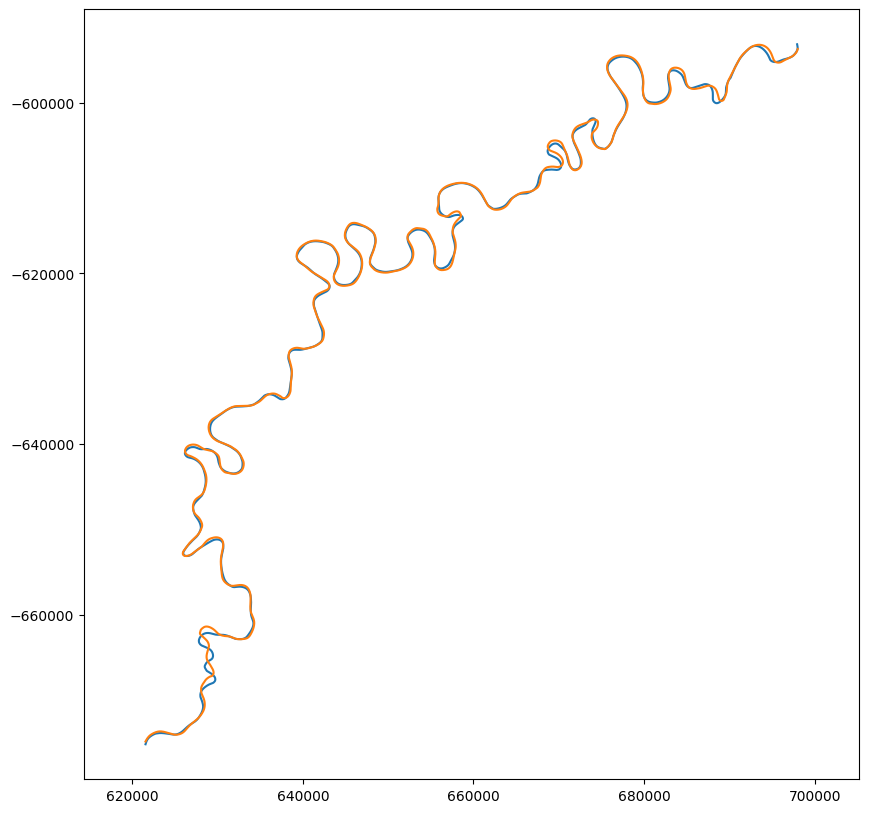

In [49]:
cl1 = pd.read_csv('Jurua_cl_1987.csv') #, index_col=None)
cl2 = pd.read_csv('Jurua_cl_2017.csv') #, index_col=None)
plt.figure(figsize=(10, 10))
plt.plot(cl1['x'], cl1['y'])
plt.plot(cl2['x'], cl2['y'])
plt.axis('equal');

In [50]:
X_axis = np.column_stack((cl1['x'], cl1['y']))
Y_axis = np.column_stack((cl2['x'], cl2['y']))

D, wp = lib_dtw(X_axis.T, Y_axis.T)

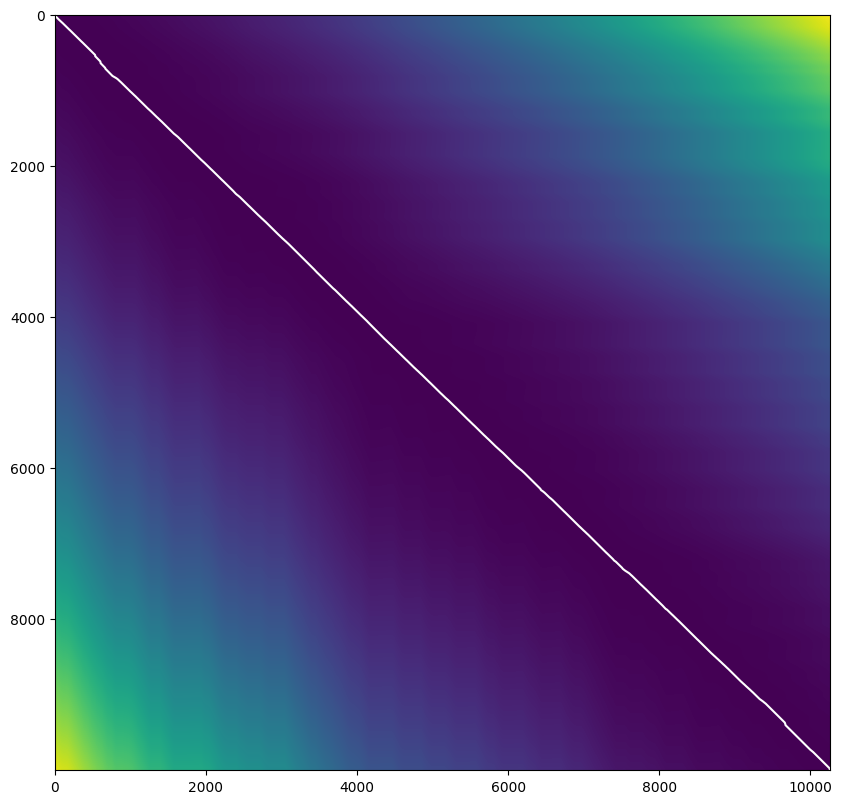

In [51]:
#Display the path
plt.figure(figsize=(10, 10))
plt.imshow(D)
plt.plot(wp[:,1], wp[:,0], 'w')

(-670000.0, -660000.0)

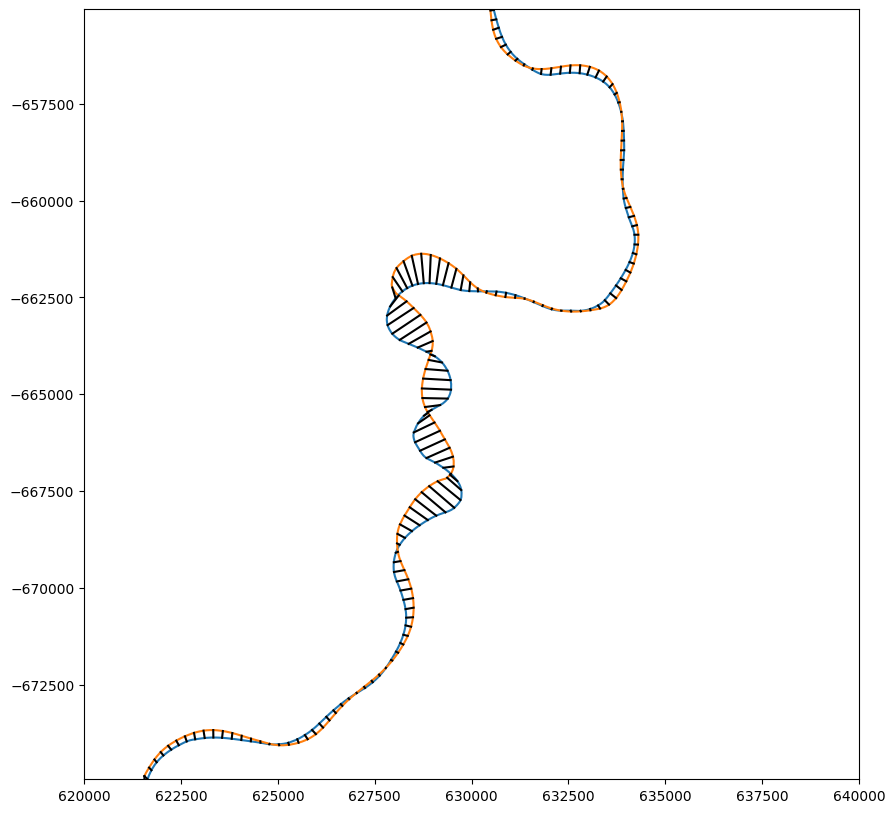

In [53]:
plt.figure(figsize=(10, 10))
plt.plot(cl1['x'], cl1['y'])
plt.plot(cl2['x'], cl2['y'])

x1=X_axis[wp[::10,0],0]
y1=X_axis[wp[::10,0],1]
x2=Y_axis[wp[::10,1],0]
y2=Y_axis[wp[::10,1],1]

# Connect the two datasets

plt.plot([x1, x2], [y1, y2], color='k')
plt.axis('equal');
plt.xlim(620000,640000)
plt.ylim(-670000,-660000)

# Task 2

Use the same approach and data as in the 'Unsupervised' session (https://github.com/UT-GEOML/GEO398D/blob/main/10-Unsupervised.ipynb) to extract sesimic wavelets from the data and then run clustering on the wavelets, using DTW as the distance measure. Try this only on a few hundred wavelets first to avoid long compute times.

In [55]:
import os
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')
# change the directory name below to your local path
dirname = '/content/gdrive/MyDrive'
#dirname = '/users/sfomel/Downloads'

# Seismic data in raw binary format
filename = os.path.join(dirname, 'seismic.bin')

# memmap maps memory of the file on disk to a numpy array
nt, nx, ny = 2001, 1161, 601
seismic = np.memmap(filename, dtype=np.int16, shape=(ny, nx, nt))

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install tslearn

In [ ]:
section = seismic[100,:,:1001].T

from scipy.signal import hilbert
envelope = np.abs(hilbert(section))

# keep only envelope above 90% percentile
threshold = np.quantile(envelope, 0.8)
envelope_t = envelope[:]
envelope_t[envelope < threshold] = 0

In [ ]:
from scipy.signal import find_peaks

wavelets = []
picks = []

nw = 41      # wavelet length
ntmax = 1001 # maximum time samples

ntraces = section.shape[1]
for k in range(ntraces):
    trace = section[:, k]
    etrace = envelope_t[:, k]
    # find local maxima
    peaks, _ = find_peaks(etrace)
    for peak in peaks:
        if peak > nw and peak < ntmax-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            if wavelet[nw//2] == wavelet.max():
                wavelets.append(wavelet)
                picks.append((k, peak))

print(f'Extracted {len(wavelets)} wavelets')

In [ ]:
waveletsn=wavelets[:7539]
picksn=picks[:7539]

In [ ]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
n_clusters = 5
X = to_time_series_dataset(waveletsn) # convert to time series dataset
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw") # k-means clustering model instance
labels = km.fit_predict(X) # fit model to data

In [ ]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers

def plot_seismic(section, title, cmap='gray'):
    plt.imshow(section, cmap=cmap, vmin=-2000, vmax=2000, aspect=0.5)
    xticks = np.arange(0, section.shape[1], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)
    yticks = np.arange(0, section.shape[0], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)
    plt.title(title, fontsize=20)

In [ ]:
pick_marks = np.array(picksn)
pick_colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(15, 7.5))
plot_seismic(section, 'Crossline #100')
plt.scatter(pick_marks[:, 0], pick_marks[:, 1],
            color=pick_colors[labels],
            marker='.')
plt.show()